In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
print("measurement schema")
column_measurement = inspector.get_columns('measurement')
for column in column_measurement:
    print(column["name"],column["type"])

print("***********")
print("STATION SCHEMA")    
column_measurement = inspector.get_columns('station')
for column in column_measurement:
    print(column["name"],column["type"])

measurement schema
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
***********
STATION SCHEMA
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

Today is : 2018-10-04
Date One Year Before Today : 2017-10-04
SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date >= ? ORDER BY measurement.date


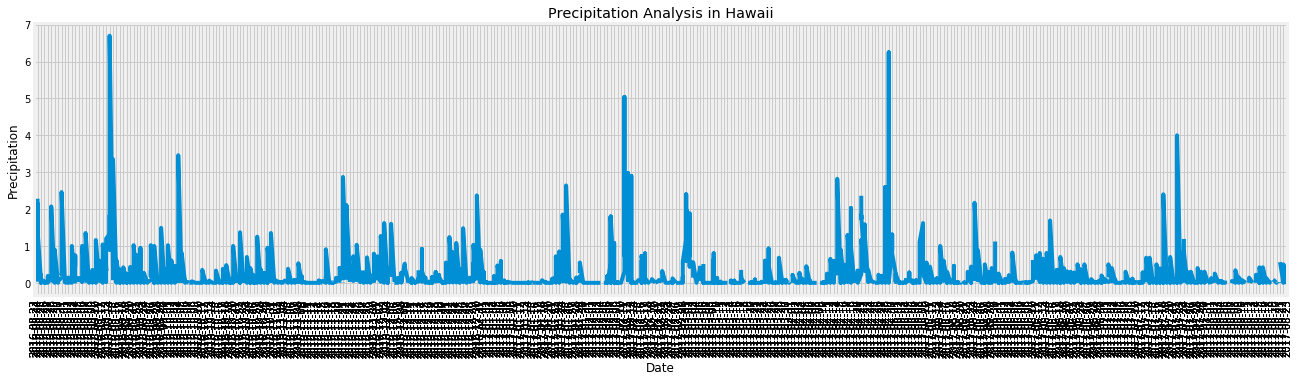

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = latest_date[0]
year_before_latest = dt.date(*(int(s) for s in last_date.split('-')))  - dt.timedelta(days=365)


# Calculate the date 1 year ago from today
date_One_year_Before = dt.date.today() - dt.timedelta(days=365) 
print("Today is : " + str(dt.date.today()))
print("Date One Year Before Today : " + str(date_One_year_Before))

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_before_latest).order_by(Measurement.date)

print(precipitation_data)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql(precipitation_data.statement, precipitation_data.session.bind)
precip_df.set_index('date', inplace = True)
precip_df.head(5)

# Sort the dataframe by date
precip_df.sort_values(by=['date'])


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,5))
plt.plot(precip_df.index, precip_df["prcp"])

# Rotate the xticks for the dates
plt.xticks(precip_df.index, rotation='vertical')
plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.xlim('2016-08-23','2017-08-23')
plt.title("Precipitation Analysis in Hawaii")
plt.savefig("Images/precipitation_graph.png")

plt.show()

![precipitation](Images/precipitation.png)

In [77]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [101]:
# How many stations are available in this dataset?
station_query = session.query(Measurement.station).group_by(Measurement.station)
station_result = pd.read_sql(station_query.statement, station_query.session.bind).count()
print("There are ", station_result.station , 'station')

There are  9 station


In [36]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_station_data = session.query(Measurement.station, func.count(Measurement.id)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active_station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
    func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

#tobs_df = pd.DataFrame(temp_data)
print(temp_data)

[(54.0, 85.0, 71.66378066378067)]


In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_highest_temp = active_station_data[0][0]
print(station_highest_temp)

temp_observ_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    filter(Measurement.station == station_highest_temp).\
    order_by(Measurement.date).all()

temp_observ_data_df = pd.DataFrame(temp_observ_data)
print(temp_observ_data_df)



USC00519281
         station        date  tobs
0    USC00519281  2016-08-23  77.0
1    USC00519281  2016-08-24  77.0
2    USC00519281  2016-08-25  80.0
3    USC00519281  2016-08-26  80.0
4    USC00519281  2016-08-27  75.0
5    USC00519281  2016-08-28  73.0
6    USC00519281  2016-08-29  78.0
7    USC00519281  2016-08-30  77.0
8    USC00519281  2016-08-31  78.0
9    USC00519281  2016-09-01  80.0
10   USC00519281  2016-09-02  80.0
11   USC00519281  2016-09-03  78.0
12   USC00519281  2016-09-04  78.0
13   USC00519281  2016-09-05  78.0
14   USC00519281  2016-09-06  73.0
15   USC00519281  2016-09-07  74.0
16   USC00519281  2016-09-08  80.0
17   USC00519281  2016-09-09  79.0
18   USC00519281  2016-09-10  77.0
19   USC00519281  2016-09-11  80.0
20   USC00519281  2016-09-12  76.0
21   USC00519281  2016-09-13  79.0
22   USC00519281  2016-09-14  75.0
23   USC00519281  2016-09-15  79.0
24   USC00519281  2016-09-16  78.0
25   USC00519281  2016-09-17  79.0
26   USC00519281  2016-09-18  78.0
27   USC

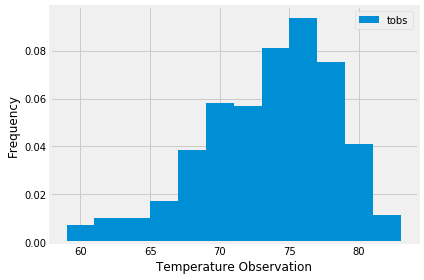

In [53]:
# plot the results as a histogram
#temp_data_df = temp_observ_data_df.set_index("date",drop=True)

plt.close(1)

#get x label value
x_value = temp_observ_data_df["tobs"]
plt.xlabel("Temperature Observation")
plt.ylabel("Frequency")

plt.hist(x_value, density =1, bins=12, label = "tobs")

#create legend
legend_x = plt.legend(fontsize="medium", loc="best")
plt.tight_layout()

plt.grid(True)

#save the figure
plt.savefig("Images/temperature_histogram.png")

#show plot
plt.show()

In [62]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return pd.DataFrame(session.query(func.min(Measurement.tobs).label("tobs_lowest"), 
            func.avg(Measurement.tobs).label("tobs_average"), 
            func.max(Measurement.tobs).label("tobs_highest")).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all())
print(calc_temps('2012-02-28', '2012-03-05'))

   tobs_lowest  tobs_average  tobs_highest
0         62.0     69.571429          74.0


In [63]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-22','2017-03-22'))

   tobs_lowest  tobs_average  tobs_highest
0         61.0     71.072626          82.0


/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


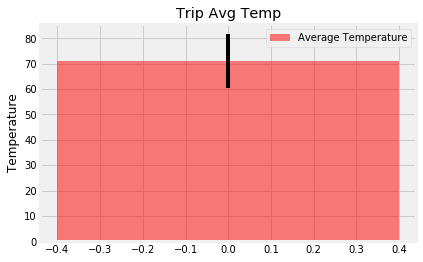

In [68]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
arr = np.arange(1)
tobs_df = calc_temps('2017-02-22','2017-03-22')
stderr = np.std([tobs_df.get_value(index=0, col='tobs_highest'),
                 tobs_df.get_value(index=0, col='tobs_lowest')])
plt.close(1)
fix, ax = plt.subplots()
ax.bar(arr,tobs_df['tobs_average'],alpha=0.5, color = 'red',
      yerr = stderr, label = 'Average Temperature')
ax.set_title("Trip Avg Temp")
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [99]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_data = session.query(Measurement,Station).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(Measurement.prcp).all()

rainfall_dict = []
for record in rainfall_data:
    (measurements, stations) = record
    list2 = [measurements.station,stations.name, stations.latitude, stations.longitude, stations.elevation, measurements.prcp]
    #print(list2)
    rainfall_dict.append(list2)
    
print(rainfall_dict)    

[['USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None], ['USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None], ['USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0], ['USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0], ['USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0], ['USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0], ['USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06], ['USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.08], ['USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.45]]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


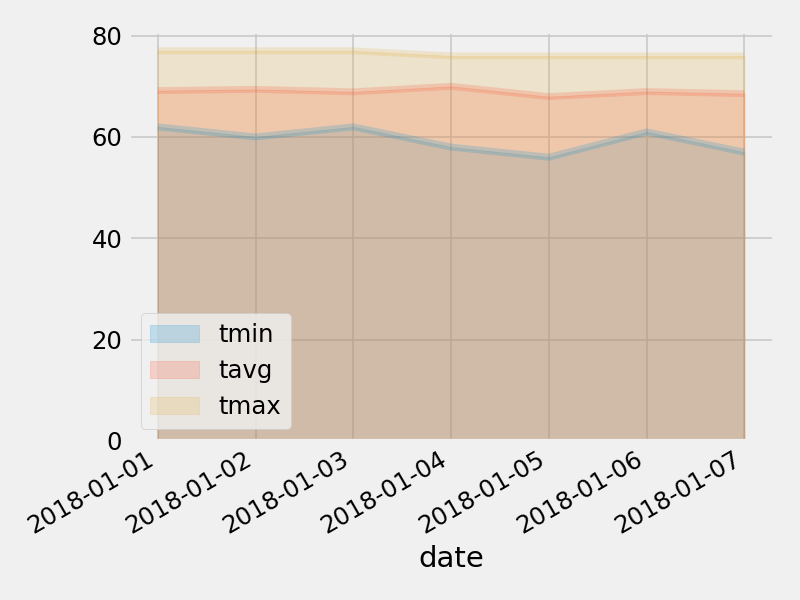

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
